# From detected synch cues, produce restamped raw Equivital and fixed intervals on march 9th, Saturday

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [2]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [3]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

In [4]:
cues_df = pd.read_csv('./outfiles/'+'Cue_dev_align_20240309.csv',index_col = 0)
for c in cues_df.columns:
    if c.endswith('dt') or c.endswith('dTime'):
        if c.startswith('dur'):
            cues_df[c] = pd.to_timedelta(cues_df[c])
        else:
            cues_df[c] = pd.to_datetime(cues_df[c])
cues_df

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU814,2024-03-09 12:29:10.411699972,-0.117188,0.755044,2024-03-09 16:43:00.334324972,0.992188,0.438914,0 days 04:13:49.922625,15229.922625,5022151,-1.109327,-0.262200,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU815,2024-03-09 12:29:10.825762472,-0.531250,0.755243,2024-03-09 16:43:00.681981222,0.644531,0.657394,0 days 04:13:49.856218750,15229.856219,5022009,-1.175733,-0.277896,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU818,2024-03-09 12:29:10.739824972,-0.445312,0.685556,2024-03-09 16:43:00.611668722,0.714844,0.486087,0 days 04:13:49.871843750,15229.871844,5022141,-1.160108,-0.274203,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU819,2024-03-09 12:29:10.814043722,-0.519531,0.561867,2024-03-09 16:43:00.584324972,0.742188,0.597215,0 days 04:13:49.770281250,15229.770281,5022006,-1.261671,-0.298208,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU820,2024-03-09 12:29:10.329668722,-0.035156,0.591183,2024-03-09 16:43:00.244481222,1.082031,0.487207,0 days 04:13:49.914812500,15229.914812,5023926,-1.117140,-0.264047,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU816,2024-03-09 12:29:10.278887472,0.015625,0.635232,2024-03-09 16:43:00.275731222,1.050781,0.661040,0 days 04:13:49.996843750,15229.996844,5022156,-1.035108,-0.244658,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU817,2024-03-09 12:29:10.360918722,-0.066406,0.667776,2024-03-09 16:43:00.271824972,1.054688,0.391168,0 days 04:13:49.910906250,15229.910906,5022073,-1.121046,-0.264970,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU812,2024-03-09 12:29:10.810137472,-0.515625,0.571462,2024-03-09 16:43:00.752293722,0.574219,0.444856,0 days 04:13:49.942156250,15229.942156,5022241,-1.089796,-0.257584,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU813,2024-03-09 12:29:10.896074972,-0.601562,0.809390,2024-03-09 16:43:01.240574972,0.085938,0.541085,0 days 04:13:50.344500,15230.344500,5022244,-0.687452,-0.162486,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853


In [5]:
# {'cue1_20240309': Timestamp('2024-03-09 12:29:20.294512472'),
#  'cue2_20240309': Timestamp('2024-03-09 16:43:11.326464853')}
df_timings = pd.DataFrame(columns=['Event','Event_Type','SS_sTime','SS_dTime'])
Event_data = {'Event':'','Event_Type':'','SS_sTime':0,'SS_dTime':pd.to_timedelta('nan')}
# start of the synch spider audio 
sync_start = (pd.to_datetime('2024-03-09 12:29:20.294512472')-pd.to_timedelta(20.294512,unit='s')).tz_localize(None)

In [6]:
# 19059.7765
i=0
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_Start'
event_dets['SS_sTime']= 20.294512
event_dets['SS_dTime']= pd.to_datetime('2024-03-09 12:29:20.294512472').tz_localize(None)
df_timings.loc[i,:]=event_dets

i=1
event_dets = Event_data.copy()
event_dets['Event']='Sync'
event_dets['Event_Type']='Sync_End'
event_dets['SS_sTime']= 15251.326465
event_dets['SS_dTime']= pd.to_datetime('2024-03-09 16:43:11.326464853').tz_localize(None) 
df_timings.loc[i,:]=event_dets

i=2
event_dets = Event_data.copy()
event_dets['Event']='C7'
event_dets['Event_Type']='Concert_Start'
event_dets['SS_sTime']= 9335.213
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets
# C5 tuning 6223.778
# C6 tuning 284.247 + 12170.971
i=3
event_dets = Event_data.copy()
event_dets['Event']='C7'
event_dets['Event_Type']='Concert_End'
event_dets['SS_sTime']= 12170.971 + 404.392
event_dets['SS_dTime']= sync_start + pd.to_timedelta(event_dets['SS_sTime'],unit='s')
df_timings.loc[i,:]=event_dets


df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,20.294512,2024-03-09 12:29:20.294512472
1,Sync,Sync_End,15251.326465,2024-03-09 16:43:11.326464853
2,C7,Concert_Start,9335.213,2024-03-09 15:04:35.213000472
3,C7,Concert_End,12575.363,2024-03-09 15:58:35.363000472


In [7]:
for ev in ['C7']:
    df_t = df_timings.query('Event == @ev').reset_index(drop = True)
    print(df_t)

  Event     Event_Type   SS_sTime                       SS_dTime
0    C7  Concert_Start   9335.213  2024-03-09 15:04:35.213000472
1    C7    Concert_End  12575.363  2024-03-09 15:58:35.363000472


In [8]:
['VN211','VN101']
df_drifts=pd.read_csv('./outfiles/'+'dev_drift.csv', index_col=0)
df_drifts.loc['VN101','median_C']

1.0001486075507473

In [9]:
df_shifts=pd.read_csv('./outfiles/Cue_dev_align_20240309.csv', index_col=0)
df_shifts['Cue1_devdTime'] = pd.to_datetime(df_shifts['Cue1_devdTime']).dt.tz_localize(None)
df_shifts['Cue2_devdTime'] = pd.to_datetime(df_shifts['Cue2_devdTime']).dt.tz_localize(None)
df_shifts['dur_dt'] = pd.to_timedelta(df_shifts['dur_dt'])
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU814,2024-03-09 12:29:10.411699972,-0.117188,0.755044,2024-03-09 16:43:00.334324972,0.992188,0.438914,0 days 04:13:49.922625,15229.922625,5022151,-1.109327,-0.262200,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU815,2024-03-09 12:29:10.825762472,-0.531250,0.755243,2024-03-09 16:43:00.681981222,0.644531,0.657394,0 days 04:13:49.856218750,15229.856219,5022009,-1.175733,-0.277896,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU818,2024-03-09 12:29:10.739824972,-0.445312,0.685556,2024-03-09 16:43:00.611668722,0.714844,0.486087,0 days 04:13:49.871843750,15229.871844,5022141,-1.160108,-0.274203,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU819,2024-03-09 12:29:10.814043722,-0.519531,0.561867,2024-03-09 16:43:00.584324972,0.742188,0.597215,0 days 04:13:49.770281250,15229.770281,5022006,-1.261671,-0.298208,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU820,2024-03-09 12:29:10.329668722,-0.035156,0.591183,2024-03-09 16:43:00.244481222,1.082031,0.487207,0 days 04:13:49.914812500,15229.914812,5023926,-1.117140,-0.264047,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU816,2024-03-09 12:29:10.278887472,0.015625,0.635232,2024-03-09 16:43:00.275731222,1.050781,0.661040,0 days 04:13:49.996843750,15229.996844,5022156,-1.035108,-0.244658,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU817,2024-03-09 12:29:10.360918722,-0.066406,0.667776,2024-03-09 16:43:00.271824972,1.054688,0.391168,0 days 04:13:49.910906250,15229.910906,5022073,-1.121046,-0.264970,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU812,2024-03-09 12:29:10.810137472,-0.515625,0.571462,2024-03-09 16:43:00.752293722,0.574219,0.444856,0 days 04:13:49.942156250,15229.942156,5022241,-1.089796,-0.257584,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU813,2024-03-09 12:29:10.896074972,-0.601562,0.809390,2024-03-09 16:43:01.240574972,0.085938,0.541085,0 days 04:13:50.344500,15230.344500,5022244,-0.687452,-0.162486,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853


In [11]:
data_dir='/Volumes/SeagateHub/BiC2024/20240309/Equivital/Extracted SEM Data/'

sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
AU814,DATA,5022151,240309,0,DATA-AU814-5022151-24030900.CSV,csv,92568,2024-03-09 12:19:38+00:00,2024-03-09 16:55:53+00:00,16575.0,...,[AU814],5022151.0,AU814,53.0,0,100.0,0.0,1.0,Stationary,Side
AU815,DATA,5022009,240309,0,DATA-AU815-5022009-24030900.CSV,csv,92383,2024-03-09 12:19:39+00:00,2024-03-09 16:56:09+00:00,16590.0,...,[AU815],5022009.0,AU815,53.0,0,100.0,1.0,1.0,Stationary,Side
AU818,DATA,5022141,240309,0,DATA-AU818-5022141-24030900.CSV,csv,90182,2024-03-09 12:19:41+00:00,2024-03-09 16:49:41+00:00,16200.0,...,[AU818],5022141.0,AU818,53.0,2,100.0,0.0,1.0,Stationary,Side
AU819,DATA,5022006,240309,0,DATA-AU819-5022006-24030900.CSV,csv,92167,2024-03-09 12:19:42+00:00,2024-03-09 16:56:12+00:00,16590.0,...,[AU819],5022006.0,AU819,53.0,0,100.0,1.0,1.0,Stationary,Side
AU820,DATA,5023926,240309,0,DATA-AU820-5023926-24030900.CSV,csv,90082,2024-03-09 12:19:43+00:00,2024-03-09 16:49:43+00:00,16200.0,...,[AU820],5023926.0,AU820,53.0,0,100.0,1.0,1.0,Stationary,Side


# Test Realign and cut

In [12]:
# pid = 'VN105'
pid = 'AU818'
dets = df_datafiles.loc[pid,:]
dets

Signal                                                            DATA
ID                                                             5022141
Date                                                            240309
Session                                                              0
FileName                               DATA-AU818-5022141-24030900.CSV
FileType                                                           csv
FileSize                                                         90182
RecStart                                     2024-03-09 12:19:41+00:00
RecEnd                                       2024-03-09 16:49:41+00:00
Duration                                                       16200.0
BatteryStart                                                      4082
BatteryEnd                                                        3965
BatteryChange(mV)                                                 -117
FullLoc              /Volumes/SeagateHub/BiC2024/20240309/Equivital...
DATAlo

In [13]:
df_shifts.loc[pid,:]

Cue1_devdTime                          2024-03-09 12:29:10.739824972
Cue1_s                                                     -0.445312
Cue1_r                                                      0.685556
Cue2_devdTime                          2024-03-09 16:43:00.611668722
Cue2_s                                                      0.714844
Cue2_r                                                      0.486087
dur_dt                                     0 days 04:13:49.871843750
dur_s                                                   15229.871844
devID                                                        5022141
drift_s                                                    -1.160108
drift_rate_sphr                                            -0.274203
ACCFile            /Volumes/Seagatehub/BiC2024/20240309/Equivital...
Cue1_file                               ./outfiles/cue1_20240309.csv
Cue1_name                                              cue1_20240309
Cue1_dt                           

In [14]:
df_timings

,Event,Event_Type,SS_sTime,SS_dTime
0,Sync,Sync_Start,20.294512,2024-03-09 12:29:20.294512472
1,Sync,Sync_End,15251.326465,2024-03-09 16:43:11.326464853
2,C7,Concert_Start,9335.213,2024-03-09 15:04:35.213000472
3,C7,Concert_End,12575.363,2024-03-09 15:58:35.363000472


In [15]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
V

,DateTime,Vert Accelerometer,Lat Accelerometer,Long Accelerometer
0,2024-03-09 12:19:13.007+00:00,0,0,0
1,2024-03-09 12:19:13.011+00:00,0,0,0
2,2024-03-09 12:19:13.015+00:00,0,0,0
3,2024-03-09 12:19:13.019+00:00,0,0,0
4,2024-03-09 12:19:13.023+00:00,0,0,0
...,...,...,...,...
4156724,2024-03-09 16:49:50.183+00:00,20,-23,-956
4156725,2024-03-09 16:49:50.187+00:00,12,-23,-944
4156726,2024-03-09 16:49:50.191+00:00,12,-43,-944
4156727,2024-03-09 16:49:50.195+00:00,0,-35,-963


In [16]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df


In [17]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime']).dt.tz_localize(None)
ACC[['X','Y','Z']] = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']].diff()).sum(axis=1))

#ACC = remove_tz_from_dataframe(ACC)
ACC.iloc[:5,:]

,dev_dTime,X,Y,Z,signal
0,2024-03-09 12:19:13.007,0,0,0,0.0
1,2024-03-09 12:19:13.011,0,0,0,0.0
2,2024-03-09 12:19:13.015,0,0,0,0.0
3,2024-03-09 12:19:13.019,0,0,0,0.0
4,2024-03-09 12:19:13.023,0,0,0,0.0


In [18]:
sync1_s = 0
sync1_dt = df_timings.loc[0,'SS_dTime']
sync2_s = df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime']
sync2_dt = df_timings.loc[1,'SS_dTime']

In [19]:
df_shifts.loc[pid,:]

Cue1_devdTime                          2024-03-09 12:29:10.739824972
Cue1_s                                                     -0.445312
Cue1_r                                                      0.685556
Cue2_devdTime                          2024-03-09 16:43:00.611668722
Cue2_s                                                      0.714844
Cue2_r                                                      0.486087
dur_dt                                     0 days 04:13:49.871843750
dur_s                                                   15229.871844
devID                                                        5022141
drift_s                                                    -1.160108
drift_rate_sphr                                            -0.274203
ACCFile            /Volumes/Seagatehub/BiC2024/20240309/Equivital...
Cue1_file                               ./outfiles/cue1_20240309.csv
Cue1_name                                              cue1_20240309
Cue1_dt                           

In [20]:
drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
drift_C

1.0000761733264705

In [21]:
drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()

ACC['rTime_s'] =np.round((ACC['dev_dTime']-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,3)+df_timings.loc[0,'SS_sTime']
#  df_timings.loc[0,'SS_sTime'] + 
ACC['rTime_dt'] = pd.to_timedelta(ACC['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
ACC.iloc[:5,:]

,dev_dTime,X,Y,Z,signal,rTime_s,rTime_dt
0,2024-03-09 12:19:13.007,0,0,0,0.0,-577.483488,2024-03-09 12:19:22.516512472
1,2024-03-09 12:19:13.011,0,0,0,0.0,-577.479488,2024-03-09 12:19:22.520512472
2,2024-03-09 12:19:13.015,0,0,0,0.0,-577.475488,2024-03-09 12:19:22.524512472
3,2024-03-09 12:19:13.019,0,0,0,0.0,-577.471488,2024-03-09 12:19:22.528512472
4,2024-03-09 12:19:13.023,0,0,0,0.0,-577.467488,2024-03-09 12:19:22.532512472


In [22]:
ACC1 = ACC.copy()

Test out put: are these two signals aligned in rTime_s, in rTime_dt?

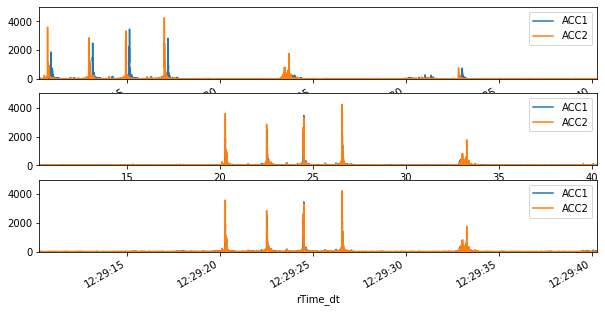

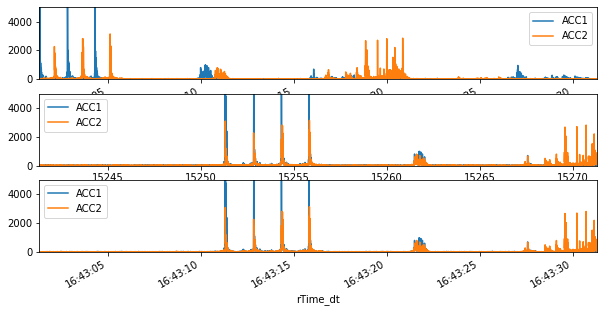

In [39]:
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[0,'SS_sTime']-10,df_timings.loc[0,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[0,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[0,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
    
fig, axes = plt.subplots(3,1,figsize=(10,5))
time_cs = ['dev_dTime','rTime_s','rTime_dt']
for i in range(len(time_cs)):
    time_c = time_cs[i]
    ACC1.plot(x=time_c,y='signal',label='ACC1',ax=axes[i])
    ACC.plot(x=time_c,y='signal',label='ACC2',ax=axes[i])
    if time_c.endswith('s'):
        axes[i].set_xlim([df_timings.loc[1,'SS_sTime']-10,df_timings.loc[1,'SS_sTime']+20])
    else:
        axes[i].set_xlim([df_timings.loc[1,'SS_dTime']-pd.to_timedelta(10,unit='s'),df_timings.loc[1,'SS_dTime']+pd.to_timedelta(20,unit='s')])
    axes[i].set_ylim([0,5000])
plt.show()
     

# Output full and for each event


In [25]:
CUTLOGS = pd.concat([df_datafiles,df_shifts],axis=1)

In [29]:
CUTLOGS.index[:20]

Index(['AU814', 'AU815', 'AU818', 'AU819', 'AU820', 'AU816', 'AU817', 'AU812',
       'AU813', 'VN110', 'PC702', 'BR609', 'VN111', 'VN212', 'VN104', 'VN101',
       'BR604', 'LS407', 'LS401', 'BR606'],
      dtype='object', name='DevName')

In [31]:
CUTLOGS = pd.concat([df_datafiles,df_shifts],axis=1)#,CUTLOGS
CUTS= pd.Series()
CUTS[pid] = []

#['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']
# newdata_dir='/Volumes/TaeTae/Stavangar/20240307/'
# data_dir='/Volumes/SeagateHub/BiC2024/Equivital/Extracted SEM Data/'
newdata_dir='/Volumes/SeagateHub/BiC2024_Synced/Equivital/'

sig_map = {'DATAloc':'EQDATA','ACCloc':'EQBACC','RESPloc':'EQRESP','RRloc':'EQCIBI','ECGloc':'EQ2ECG'}
cut_ind = 0
toc = time.time()
rec_day = '20240309'
buff = pd.to_timedelta(15,unit='s') # 2 minute buffer on cutes for concert and stuff pd.to_timedelta(RecTimeSig['rec_sTime'] - ap['Cue0_rst'],unit='s')
segmentid = 'FULL'
for pid in CUTLOGS.index[:20]:
# for pid in CUTLOGS.index[20:]: # had to restart after VN212 as that is missing 
    tic = time.time()
    outfiles = []
    tic = time.time()
#     if pid == 'VN101':
#         drift_C = df_drifts.loc['VN101','median_C']
#     else: 
    drift_C = (df_timings.loc[1,'SS_sTime'] - df_timings.loc[0,'SS_sTime'])/(df_shifts.loc[pid,'Cue2_devdTime']-df_shifts.loc[pid,'Cue1_devdTime']).total_seconds()
    eqfiles = df_datafiles.loc[pid,['DATAloc','ACCloc','RESPloc','RRloc','ECGloc']]
    for f in eqfiles.index:
        SignalID = sig_map[f]
        V = pd.read_csv(eqfiles[f],skipinitialspace=True)
        dt_col = V.columns[0] # assume first column is time, specifically datetime
        sig_col = V.columns[1:]
        V[dt_col]=pd.to_datetime(V[dt_col]).dt.tz_localize(None) # .dt.tz_localize('Europe/Oslo').dt.tz_convert('UTC')

        V['rTime_s'] =np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        V['rTime_dt'] = pd.to_timedelta(V['rTime_s']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig = pd.DataFrame()
        RecTimeSig['rec_sTime'] = np.round((V[dt_col]-df_shifts.loc[pid,'Cue1_devdTime']).dt.total_seconds()*drift_C,4)+df_timings.loc[0,'SS_sTime']
        RecTimeSig['rec_dTime'] = pd.to_timedelta(RecTimeSig['rec_sTime']-df_timings.loc[0,'SS_sTime'],unit='s')+ sync1_dt
        RecTimeSig['dev_dTime'] = V[dt_col]
        RecTimeSig.loc[:,sig_col] = V[sig_col]
        
        seg_filename = '_'.join([pid,rec_day,'FULL',SignalID+'.csv'])
        new_col_order=['rec_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        RecTimeSig[new_col_order].to_csv(newdata_dir + 'FullDay/'+ rec_day+ '/'+ seg_filename, index = False)

        new_col_order=['c_sTime']+list(sig_col) + ['rec_dTime','dev_dTime']
        
        # run through events in that section
        ev = 'C7'
        df_t = df_timings.query('Event == @ev').reset_index(drop = True)
        subsig  = al.dt_cut(RecTimeSig,'rec_dTime',df_t.loc[0,'SS_dTime']-buff,df_t.loc[1,'SS_dTime']+buff)
        if subsig is not None:
            subsig['c_sTime'] = np.round((subsig['rec_dTime']-df_t.loc[0,'SS_dTime']).dt.total_seconds(),4)
            seg_filename = '_'.join([ev,segmentid,pid,SignalID+'.csv'])
            outfiles.append(seg_filename)
            subsig[new_col_order].to_csv(newdata_dir + ev+'/' + seg_filename, index = False)

        print(' '.join([pid,SignalID ,str(np.round(time.time() - tic,3)),str(np.round(time.time() - toc,3))]))
    CUTS[pid] = outfiles

# CUTS= pd.Series()
# CUTS[pid] = []
CUTLOGS['Output_files']=CUTS
# CUTLOGS.to_csv('./outfiles/'+rec_day+'EQIVITALS_CUTLOGS.csv')
# CUTLOGS['Scaling_C'].hist()
# plt.show()
CUTLOGS

AU814 EQDATA 0.222 0.223
AU814 EQBACC 49.69 49.69
AU814 EQRESP 54.42 54.421
AU814 EQCIBI 54.65 54.651
AU814 EQ2ECG 107.62 107.621
AU815 EQDATA 0.113 107.735
AU815 EQBACC 50.206 157.828
AU815 EQRESP 54.977 162.599
AU815 EQCIBI 55.198 162.819
AU815 EQ2ECG 106.453 214.075
AU818 EQDATA 0.122 214.197
AU818 EQBACC 48.077 262.153
AU818 EQRESP 52.741 266.816
AU818 EQCIBI 52.916 266.991
AU818 EQ2ECG 103.162 317.238
AU819 EQDATA 0.128 317.366
AU819 EQBACC 49.246 366.484
AU819 EQRESP 54.053 371.291
AU819 EQCIBI 54.225 371.463
AU819 EQ2ECG 105.235 422.473
AU820 EQDATA 0.125 422.599
AU820 EQBACC 52.841 475.315
AU820 EQRESP 57.431 479.905
AU820 EQCIBI 57.607 480.081
AU820 EQ2ECG 113.515 535.989
AU816 EQDATA 0.11 536.099
AU816 EQBACC 48.39 584.38
AU816 EQRESP 53.076 589.066
AU816 EQCIBI 53.311 589.301
AU816 EQ2ECG 102.689 638.678
AU817 EQDATA 0.126 638.805
AU817 EQBACC 48.673 687.352
AU817 EQRESP 53.207 691.886
AU817 EQCIBI 53.4 692.079
AU817 EQ2ECG 105.436 744.115
AU812 EQDATA 0.096 744.213
AU812 EQ

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt,Output_files
DevName,,,,,,,,,,,,,,,,,,,,,
AU814,DATA,5022151,240309,0,DATA-AU814-5022151-24030900.CSV,csv,92568,2024-03-09 12:19:38+00:00,2024-03-09 16:55:53+00:00,16575.0,...,-1.109327,-0.262200,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU814_EQDATA.csv, C7_FULL_AU814_EQBAC..."
AU815,DATA,5022009,240309,0,DATA-AU815-5022009-24030900.CSV,csv,92383,2024-03-09 12:19:39+00:00,2024-03-09 16:56:09+00:00,16590.0,...,-1.175733,-0.277896,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU815_EQDATA.csv, C7_FULL_AU815_EQBAC..."
AU818,DATA,5022141,240309,0,DATA-AU818-5022141-24030900.CSV,csv,90182,2024-03-09 12:19:41+00:00,2024-03-09 16:49:41+00:00,16200.0,...,-1.160108,-0.274203,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU818_EQDATA.csv, C7_FULL_AU818_EQBAC..."
AU819,DATA,5022006,240309,0,DATA-AU819-5022006-24030900.CSV,csv,92167,2024-03-09 12:19:42+00:00,2024-03-09 16:56:12+00:00,16590.0,...,-1.261671,-0.298208,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU819_EQDATA.csv, C7_FULL_AU819_EQBAC..."
AU820,DATA,5023926,240309,0,DATA-AU820-5023926-24030900.CSV,csv,90082,2024-03-09 12:19:43+00:00,2024-03-09 16:49:43+00:00,16200.0,...,-1.117140,-0.264047,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU820_EQDATA.csv, C7_FULL_AU820_EQBAC..."
AU816,DATA,5022156,240309,0,DATA-AU816-5022156-24030900.CSV,csv,92543,2024-03-09 12:19:46+00:00,2024-03-09 16:56:16+00:00,16590.0,...,-1.035108,-0.244658,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU816_EQDATA.csv, C7_FULL_AU816_EQBAC..."
AU817,DATA,5022073,240309,0,DATA-AU817-5022073-24030900.CSV,csv,92284,2024-03-09 12:20:02+00:00,2024-03-09 16:56:02+00:00,16560.0,...,-1.121046,-0.264970,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU817_EQDATA.csv, C7_FULL_AU817_EQBAC..."
AU812,DATA,5022241,240309,0,DATA-AU812-5022241-24030900.CSV,csv,90477,2024-03-09 12:20:05+00:00,2024-03-09 16:49:35+00:00,16170.0,...,-1.089796,-0.257584,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU812_EQDATA.csv, C7_FULL_AU812_EQBAC..."
AU813,DATA,5022244,240309,0,DATA-AU813-5022244-24030900.CSV,csv,90274,2024-03-09 12:20:07+00:00,2024-03-09 16:49:38+00:00,16171.0,...,-0.687452,-0.162486,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853,"[C7_FULL_AU813_EQDATA.csv, C7_FULL_AU813_EQBAC..."


In [ ]:
VN105,WW506,BR608,VA305,PC709,VN206,LS410,WW508,VN211,VA304,VA309,LS409,LS404,
VN201,VN109,WW507,PC710,LS405,BR605,WW504

In [64]:
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             3420426
Date                                                            240308
Session                                                              0
FileName                               DATA-AU802-3420426-24030800.CSV
FileType                                                           csv
FileSize                                                        156433
RecStart                                     2024-03-08 06:34:21+00:00
RecEnd                                       2024-03-08 14:25:51+00:00
Duration                                                       28290.0
BatteryStart                                                      4123
BatteryEnd                                                        3953
BatteryChange(mV)                                                 -170
FullLoc              /Volumes/SeagateHub/BiC2024/20240308/Equivital...
DATAlo

In [47]:
eqfiles

DATAloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ACCloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RESPloc    /Volumes/SeagateHub/BiC2024/20240308/Equivital...
RRloc      /Volumes/SeagateHub/BiC2024/20240308/Equivital...
ECGloc     /Volumes/SeagateHub/BiC2024/20240308/Equivital...
Name: VN211, dtype: object

In [ ]:
# 4099.328 for all segments